In [1]:
import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

import sys
sys.path.insert(0, "Code/")

from BatchManager import BatchManager

from Search import *


In [2]:
# Load the data

df = pd.read_csv("Data/adult.csv")

# Process the categorical variables

df = pd.get_dummies(df, columns=["workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country"])

df["income"] = df["income"].map({ "<=50K": 0, ">50K": 1 })

names = list(df)

# Setup for training and testing models

y = df["income"].values.astype('float32')
y = np.expand_dims(y, 1)
df.drop("income", axis = 1, inplace = True)

x = df.values.astype('float32')

x = x - np.min(x, axis = 0)
x = x / np.max(x, axis = 0)

d = x.shape[1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5)
x_val, x_test, y_val, y_test = train_test_split(x_train, y_train, test_size = 0.5)


In [3]:

shape = [200, 200, 200]

batch_size = 2048
learning_rate = 0.05
min_epochs = 10
stopping_epochs = 5
tol = 0.001

bm = BatchManager(x_train, y_train) # TODO:  use a tf dataset object (it is probably faster)
batch_per_epoch = int(x_train.shape[0] / batch_size)

# Build the model
model = Sequential()
model.add(Dense(shape[0], activation = 'relu', input_dim = d))
for i in range(1, len(shape)):
    model.add(Dense(shape[i], activation = 'relu'))
model.add(Dense(1))

print(model.summary())

def loss(model, x, y):
    logits = model(x)
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = y))

def prob(model, x):
    return tf.math.sigmoid(model(x))

def acc(model, x, y):
    return tf.reduce_mean(tf.cast(tf.equal(tf.round(prob(model, x)), y), tf.float32))

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

epoch = 0
best_epoch = 0
best_loss = np.inf

train_loss = []
val_loss = []
train_acc = []
val_acc = []

while True:

    # Stopping condition
    if epoch - best_epoch > stopping_epochs and epoch > min_epochs:
        break
        
    # Train for an epoch
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    for i in range(batch_per_epoch):
        x_batch, y_batch = bm.next_batch(batch_size = batch_size)
        
        loss_value, grads = grad(model, x_batch, y_batch)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        epoch_loss_avg.update_state(loss_value)
        epoch_acc_avg.update_state(acc(model, x_batch, y_batch))
        

    train_loss.append(epoch_loss_avg.result())
    train_acc.append(epoch_acc_avg.result())
    
    # Check for convergence
    v_l = loss(model, x_val, y_val)
    v_a = acc(model, x_val, y_val)

    val_loss.append(v_l)
    val_acc.append(v_a)
    
    if v_l < best_loss - tol:
        best_loss = v_l
        best_epoch = epoch
        model.save_weights('2-Adult-MLP/model')
    
    # Update counter
    epoch += 1
    
model.load_weights('2-Adult-MLP/model')

print("Train Acc: ", acc(model, x_train, y_train).numpy())
print("Test Acc: ", acc(model, x_test, y_test).numpy())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               21800     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 102,401
Trainable params: 102,401
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train Acc:  0.85320014
Test Acc:  0.8526738


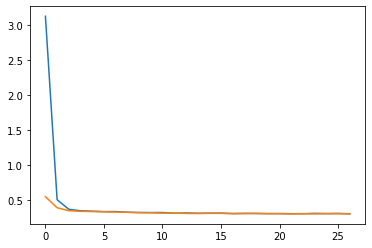

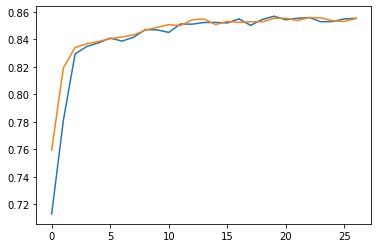

In [4]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()
plt.close()

plt.plot(train_acc)
plt.plot(val_acc)
plt.show()
plt.close()

In [5]:
# Define the base components for the search

def pred(x):
    return prob(model, x)

# h is the perturbation
def perturber_continuous(model, x, h):
    x_pert = x + h
    y_pert = model(x_pert)
    return x_pert, y_pert

def checker_prob(y, y_pert, min_change = 0.05):
    return 1.0 * (np.abs(y_pert - y) >= min_change)

def checker_label(y, y_pert):
    return 1.0 * (np.rint(y_pert) != np.rint(y))

def learner(X, success):
    region = DecisionTreeClassifier(min_samples_leaf = 20, min_impurity_decrease = 0.025)
    region.fit(X, success)
    return region


In [6]:
print("Checking for instabilities in 'Age'\n")

# Configure the perturbation
index = names.index("age")

heuristics = []
pert = np.zeros((1, d))
pert[0, index] = 0.02
heuristics.append(pert)

y_hat_train = prob(model, x_train)
y_hat_test = prob(model, x_test)

print("Using labels")
out_original = search(pred, x_train, y_hat_train, heuristics, perturber_continuous, checker_label, learner, use_val = True, X_val = x_test, y_val = y_hat_test, min_explainability = 0.9, use_acc = True, verbose = True)

print("Using probabilities")
out_original = search(pred, x_train, y_hat_train, heuristics, perturber_continuous, checker_prob, learner, use_val = True, X_val = x_test, y_val = y_hat_test, min_explainability = 0.9, use_acc = True, verbose = True)


Checking for instabilities in 'Age'

Using labels

Heuristic:  [[0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
Success on Train:  100.0
Train Metrics:  0.9959051635887146
Success on Val:  53.0
Validation Metrics:  0.9956596511342233
Accepted

Using probabilities

Heuristic:  [[0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0